**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [5]:
y_name = 'CO(GT)'
df = pd.read_csv('airquality.csv', skipinitialspace=True, na_values='?', keep_default_na=True, sep=';')

columns2remove = ['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [6]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [7]:
res = prepare_dataset(df, y_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

/Users/riccardo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,CO(GT)
0,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,27
1,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,21
2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,23
3,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,23
4,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,17


# Data Partitioning

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [9]:
attributes = [col for col in df.columns if col != y_name]
X = df[attributes].values
y = df[y_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [26]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [ 4.99365661e-03  1.41774453e-02  7.10755606e-01 -8.46456057e-03
  4.25011049e-02 -5.49199624e-04 -4.83969457e-03  9.39771907e-03
 -2.35149966e-03 -1.40411974e-01 -7.54317695e-02 -5.50578272e-01]
Intercept: 
 4.883984192543615


In [27]:
y_pred = reg.predict(X_test)

In [29]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.765
MSE: 56.018
MAE: 4.776


## Linear Regression in 2 dimensions

In [49]:
reg = LinearRegression()
reg.fit(X_train.T[0].reshape(-1, 1), y_train)
y_pred = reg.predict(X_test.T[0].reshape(-1, 1))

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.146
MSE: 203.480
MAE: 10.608


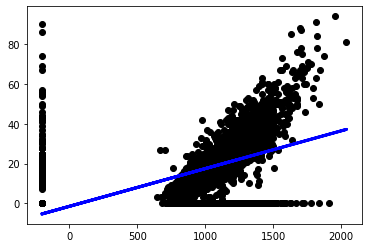

In [50]:
plt.scatter(X_test.T[0], y_test,  color='black')
plt.plot(X_test.T[0], y_pred, color='blue', linewidth=3)
plt.show()

# Lasso

In [51]:
reg = Lasso()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [ 0.00637757  0.01403048  0.          0.01389165  0.04359241  0.00330828
 -0.00647338  0.00776205 -0.00226357 -0.11463657 -0.05754968 -0.        ]
Intercept: 
 -13.43231189414249


In [52]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.766
MSE: 55.627
MAE: 4.841


# Ridge

In [53]:
reg = Ridge()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [ 4.99391141e-03  1.41771928e-02  7.10606658e-01 -8.46072287e-03
  4.25016184e-02 -5.48746979e-04 -4.84048599e-03  9.39821156e-03
 -2.35159601e-03 -1.40437295e-01 -7.54395111e-02 -5.50414444e-01]
Intercept: 
 4.881201263343142


In [54]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.765
MSE: 56.017
MAE: 4.776


# Slides Example

Coefficients: 
 [58.87472632]
Mean squared error: 3.40
Coefficient of determination: 0.93
1.432665401644528


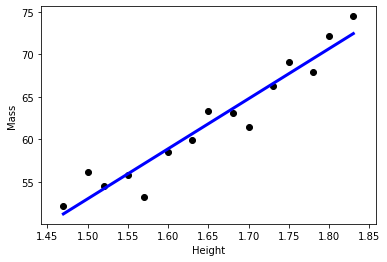

In [55]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model

Height = np.array([1.47, 1.50, 1.52, 1.55, 1.57, 1.60, 1.63, 1.65, 1.68, 1.70, 1.73, 1.75, 1.78, 1.80, 1.83])
Mass = np.array([52.21, 56.12, 54.48, 55.84, 53.20, 58.57, 59.93, 63.29, 63.11, 61.47, 66.28, 69.10, 67.92, 
                 72.19, 74.46])

diabetes_X_train = Height
diabetes_y_train = Mass

diabetes_X_test = Height
diabetes_y_test = Mass

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train.reshape(-1, 1), diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))
print(mean_absolute_error(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)
plt.xlabel('Height')
plt.ylabel('Mass')

#plt.xticks(())
#plt.yticks(())

plt.show()

# Logistic Regression

In [54]:
class_name = 'churn'
df = pd.read_csv('churn.csv', skipinitialspace=True, na_values='?', keep_default_na=True)

columns2remove = ['phone number']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [55]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

/Users/riccardo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,state=VT,state=WA,state=WI,state=WV,state=WY,international plan=no,international plan=yes,voice mail plan=no,voice mail plan=yes,churn
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,0,0,0,0,0,1,0,0,1,0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,0,0,0,0,0,1,0,0,1,0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,...,0,0,0,0,0,1,0,1,0,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,...,0,0,0,0,0,0,1,1,0,0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,...,0,0,0,0,0,0,1,1,0,0


In [56]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report

In [57]:
selected_columns = ['total day charge']

attributes = [col for col in df.columns if col != class_name]
X = df[selected_columns].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [58]:
X.shape

(3333, 1)

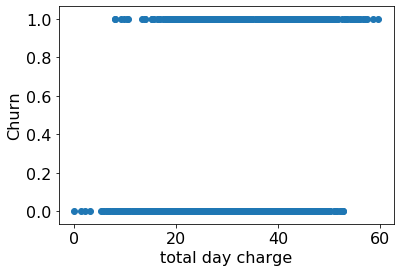

In [67]:
plt.scatter(X_train, y_train)
plt.xlabel(selected_columns[0], fontsize=16)
plt.ylabel('Churn', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.856
F1-score [0.9223301  0.01369863]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       855
           1       1.00      0.01      0.01       145

    accuracy                           0.86      1000
   macro avg       0.93      0.50      0.47      1000
weighted avg       0.88      0.86      0.79      1000



In [71]:
from scipy.special import expit

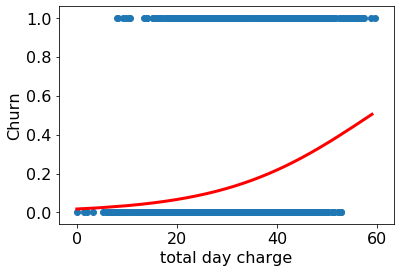

In [72]:
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(selected_columns[0], fontsize=16)
plt.ylabel('Churn', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [73]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

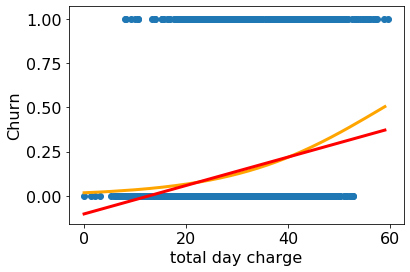

In [74]:
plt.scatter(X_train, y_train)

loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test), loss, color='orange', linewidth=3)

plt.plot(sorted(X_test), reg.coef_ * sorted(X_test) + reg.intercept_, color='red', linewidth=3)


plt.xlabel(selected_columns[0], fontsize=16)
plt.ylabel('Churn', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()